In [51]:
# Load packages
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import scipy as scp
import scipy.stats as scps
from scipy.optimize import differential_evolution
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load my own functions
import dnnregressor_train_eval_keras as dnnk
import make_data_wfpt as mdw
from kde_training_utilities import kde_load_data
import ddm_data_simulation as ddm_sim

In [52]:
# Load Model
model_path = os.getcwd() + '/keras_models/dnnregressor_kde_ddm_flexbound_05_03_19_20_15_59/model_0' 
ckpt_path = os.getcwd() + '/keras_models/dnnregressor_kde_ddm_flexbound_05_03_19_20_15_59/ckpt_0_80'
model = keras.models.load_model(model_path)
model.load_weights(ckpt_path)

In [ ]:
# Define the likelihood function DDM
def log_p_ddm(params = [0, 1, 0.9], model = [], data = []):
    feature_pd = pd.DataFrame(np.zeros((data[0].shape[0], 5)), columns = ['v', 'a', 'w', 'rt', 'choice'])
    feature_pd['rt'] = data[0]
    feature_pd['choice'] = data[1]
    feature_pd['v'] = params[0]
    feature_pd['a'] = params[1]
    feature_pd['w'] = params[2]
    prediction = model.predict(feature_pd)
    prediction[prediction < 1e-29] = 1e-29
    return(- np.sum(np.log(prediction)))

In [53]:
# Define the likelihood function DDM-FLEXBOUND
def log_p_flexbound(params = [0, 1, 0.9], model = [], data = []):
    feature_pd = pd.DataFrame(np.zeros((data[0].shape[0], 7)), columns = ['v', 'a', 'w', 'c1', 'c2', 'rt', 'choice'])
    feature_pd['rt'] = data[0]
    feature_pd['choice'] = data[1]
    feature_pd['v'] = params[0]
    feature_pd['a'] = params[1]
    feature_pd['w'] = params[2]
    feature_pd['c1'] = params[3]
    feature_pd['c2'] = params[4]
    prediction = model.predict(feature_pd)
    prediction[prediction < 1e-29] = 1e-29
    return(- np.sum(np.log(prediction)))

In [ ]:
# Run MLE 
ddm_model = 'flexbound'

# Initializations -----
n_runs = 200
n_samples = 2500
v_range = [-1, 1]
a_range = [2.999, 3.001] # previous [1,2] # previous [2, 3]
w_range = [0.499, 0.501]

if ddm_model == 'ddm':
    optim_results = pd.DataFrame(np.zeros((n_runs, 7)), columns = ['v_sim', 
                                                                   'a_sim', 
                                                                   'w_sim', 
                                                                   'v_mle', 
                                                                   'a_mle', 
                                                                   'w_mle', 
                                                                   'n_samples'])

if ddm_model == 'flexbound':
    optim_results = pd.DataFrame(np.zeros((n_runs, 11)), columns = ['v_sim', 
                                                                   'a_sim', 
                                                                   'w_sim',
                                                                   'c1_sim', # note these are boundary function parameters
                                                                   'c2_sim', # which ones go here depends on the boundary function
                                                                   'v_mle', 
                                                                   'a_mle', 
                                                                   'w_mle', 
                                                                   'c1_mle',
                                                                   'c2_mle',
                                                                   'n_samples'])
    
    # Define boundary function 
    def exp_c1_c2(t = 1, 
                  c1 = 1,
                  c2 = 1):

        b = np.exp(- c2*(t-c1))

        if t >= c1:

            return b

        else:
            return 1
        
    # Define appropriate range of parameters
    c1_range = [0, 0.001]
    c2_range = [1/3, 1]
# ---------------------

# Main loop ----------- TD: Parallelize
cnt = 1
for i in range(0, n_runs, 1): 
    
    # Sample parameters
    v_sim = np.random.uniform(high = v_range[1], low = v_range[0])
    a_sim = np.random.uniform(high = a_range[1], low = a_range[0])
    w_sim = np.random.uniform(high = w_range[1], low = w_range[0])
    
    if ddm_model == 'ddm':
        optim_results.iloc[i, 0:3] = [v_sim, a_sim, w_sim,]
        optim_results.iloc[i, 6] = n_samples
        
    if ddm_model == 'flexbound':
        c1_sim = np.random.uniform(high = c1_range[1], low = c1_range[0])
        c2_sim = np.random.uniform(high = c2_range[1], low = c2_range[0])
        
        # Store in output file
        optim_results.iloc[i, 0:5] = [v_sim, a_sim, w_sim, c1_sim, c2_sim]
        optim_results.iloc[i, 10] = n_samples
        
    
    if ddm_model == 'ddm':
        ddm_dat_tmp = ddm_sim.ddm_simulate(a = a_sim, 
                                           v = v_sim, 
                                           w = w_sim, 
                                           n_samples = n_samples)
    
    if ddm_model == 'flexbound':
        ddm_dat_tmp = ddm_sim.ddm_flexbound_simulate(v = v_sim,
                                                     a = a_sim,
                                                     w = w_sim,
                                                     s = 1,
                                                     delta_t = 0.001,
                                                     max_t = 20,
                                                     n_samples = n_samples,
                                                     boundary_fun = exp_c1_c2, # function of t (and potentially other parameters) that takes in (t, *args)
                                                     boundary_fun_type = 'exp_c1_c2',
                                                     boundary_params = {'c1': c1_sim, 'c2': c2_sim})
    
    # Run optimizer
    if ddm_model == 'ddm':
        out = differential_evolution(log_p_ddm, 
                                     bounds = [(v_range[0],v_range[1]), 
                                               (a_range[0], a_range[1]), 
                                               (w_range[0], w_range[1]),
                                               (c1_range[0], c1_range[1]),
                                               (c2_range[0], c2_range[1])], 
                                     args = (model, ddm_dat_tmp), 
                                     popsize = 30)
    if ddm_model == 'flexbound':
        out = differential_evolution(log_p_flexbound, 
                                     bounds = [(v_range[0],v_range[1]), 
                                               (a_range[0], a_range[1]), 
                                               (w_range[0], w_range[1]),
                                               (c1_range[0], c1_range[1]),
                                               (c2_range[0], c2_range[1])], 
                                     args = (model, ddm_dat_tmp), 
                                     popsize = 30)
    
    print(out.x)
    
    # Store result in output file
    if ddm_model == 'ddm':
        optim_results.iloc[i, 3:6] = out.x
        
    if ddm_model == 'flexbound':
        optim_results.iloc[i, 5:10] = out.x
    
    #Print and update counter
    print(cnt)
    cnt += 1
# -----------------------


# Save optimization results to file
optim_results.to_csv(os.getcwd() + '/experiments/ddm_flexbound_kde_mle_fix_a_3_c1_0_w_unbiased_vrange_mid/optim_results.csv')

{'boundary_fun': <function exp_c1_c2 at 0x7fcaf006f2f0>}
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
[-3.47945818e-01  2.99900000e+00  5.00953174e-01  7.75063102e-04
  5.85446794e-01]
1
{'boundary_fun': <function exp_c1_c2 at 0x7fcaf006f2f0>}
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
[-4.89198441e-01  2.99907951e+00  5.00804030e-01  6.85981278e-04
  5.47837603e-01]
2
{'boundary_fun': <function exp_c1_c2 at 0x7fcaf006f2f0>}
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
[-4.22849800e-02  3.00029731e+00  5.00718297e-01  6.19065001e-04
  7.07855643e-01]
3
{'boundary_fun': <function exp_c1_c2 at 0x7fcaf006f2f0>}
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
[-1.76385326e-01  2.99925557e+00  4.99000000e-01  5.95747247e-04
  7.77406769e-01]
4
{'boundary_fun': <function exp_c1_c2 at 0x7fcaf006f2f0>}
0  datapoints sampled
1000  datapoints sampled
2000  datapoints sampled
[1.21226958e-01

In [ ]:
# Run MLE on real data
ddm_model = 'flexbound'
data_file = os.getcwd() + 'data_storage/michael_bg_nn_data/bg_stn_full.csv'
data = pd.read_csv(data_file)
files_ = np.unique(data['file'])

# Initializations -----
v_range = [-2, 2]
a_range = [1, 3] # previous [1,2] # previous [2, 3]
w_range = [0.499, 0.501]

if ddm_model == 'ddm':
    optim_results = pd.DataFrame(np.zeros((n_runs, 7)), columns = ['file',
                                                                   'v_mle', 
                                                                   'a_mle', 
                                                                   'w_mle', 
                                                                   'n_samples'])

if ddm_model == 'flexbound':
    optim_results = pd.DataFrame(np.zeros((n_runs, 11)), columns = ['file'
                                                                   'v_mle', 
                                                                   'a_mle', 
                                                                   'w_mle', 
                                                                   'c1_mle',
                                                                   'c2_mle',
                                                                   'n_samples'])
    
    # Define boundary function 
    def exp_c1_c2(t = 1, 
                  c1 = 1,
                  c2 = 1):

        b = np.exp(- c2*(t-c1))

        if t >= c1:

            return b

        else:
            return 1
        
    # Define appropriate range of parameters
    c1_range = [0, 0.0001]
    c2_range = [1/3, 1]
# ---------------------

# Main loop ----------- TD: Parallelize
cnt = 1
for file_ in files_: 
    
    data_tmp = data.loc[data['file'] == file_,]
    data_feed_tmp = [data_tmp['avg_cycle'].values, data_tmp['cnt_err'].values]

    # Sample parameters
    v_sim = np.random.uniform(high = v_range[1], low = v_range[0])
    a_sim = np.random.uniform(high = a_range[1], low = a_range[0])
    w_sim = np.random.uniform(high = w_range[1], low = w_range[0])
    
    if ddm_model == 'ddm':
        optim_results.iloc[i, 0] = file_
        optim_results.iloc[i, 4] = n_samples
        
    if ddm_model == 'flexbound':
        c1_sim = np.random.uniform(high = c1_range[1], low = c1_range[0])
        c2_sim = np.random.uniform(high = c2_range[1], low = c2_range[0])
        
        # Store in output file
        optim_results.iloc[i, 0] = file_
        optim_results.iloc[i, 6] = data_tmp.shape[0]


    
    
    if ddm_model == 'ddm':
        ddm_dat_tmp = ddm_sim.ddm_simulate(a = a_sim, 
                                           v = v_sim, 
                                           w = w_sim, 
                                           n_samples = n_samples)
    
    if ddm_model == 'flexbound':
        ddm_dat_tmp = ddm_sim.ddm_flexbound_simulate(v = v_sim,
                                                     a = a_sim,
                                                     w = w_sim,
                                                     s = 1,
                                                     delta_t = 0.001,
                                                     max_t = 20,
                                                     n_samples = n_samples,
                                                     boundary_fun = exp_c1_c2, # function of t (and potentially other parameters) that takes in (t, *args)
                                                     boundary_fun_type = 'exp_c1_c2',
                                                     boundary_params = {'c1': c1_sim, 'c2': c2_sim})
    
    # Run optimizer
    if ddm_model == 'ddm':
        out = differential_evolution(log_p_ddm, 
                                     bounds = [(v_range[0],v_range[1]), 
                                               (a_range[0], a_range[1]), 
                                               (w_range[0], w_range[1]),
                                               (c1_range[0], c1_range[1]),
                                               (c2_range[0], c2_range[1])], 
                                     args = (model, data_feed_tmp), 
                                     popsize = 30)
    if ddm_model == 'flexbound':
        out = differential_evolution(log_p_flexbound, 
                                     bounds = [(v_range[0],v_range[1]), 
                                               (a_range[0], a_range[1]), 
                                               (w_range[0], w_range[1]),
                                               (c1_range[0], c1_range[1]),
                                               (c2_range[0], c2_range[1])], 
                                     args = (model, data_feed_tmp), 
                                     popsize = 30)
    
    print(out.x)
    
    # Store result in output file
    if ddm_model == 'ddm':
        optim_results.iloc[i, 1:4] = out.x
        
    if ddm_model == 'flexbound':
        optim_results.iloc[i, 1:6] = out.x
    
    #Print and update counter
    print(cnt)
    cnt += 1
# -----------------------


# Save optimization results to file
optim_results.to_csv(os.getcwd() + '/experiments/ddm_flexbound_kde_mle_fix_a_3_c1_0_v_0_w_unbiased/optim_results.csv')

In [5]:
optim_results.to_csv(os.getcwd() + '/experiments/optim_results.csv')

In [81]:
optim_results = pd.read_csv(os.getcwd() + '/experiments/ddm_flexbound_kde_mle_restricted_range_a_1_2/optim_results.csv')

In [103]:
optim_results.to_csv(os.getcwd() + '/experiments/ddm_flexbound_kde_mle_fix_a_3_c1_0_v_0_w_unbiased/optim_results.csv')

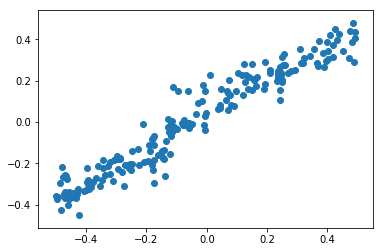

In [104]:
plt.scatter(optim_results['v_sim'], optim_results['v_mle'])

In [105]:
# Regression for v
reg = LinearRegression().fit(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))
reg.score(np.expand_dims(optim_results['v_mle'], 1), np.expand_dims(optim_results['v_sim'], 1))

0.9331841003536874

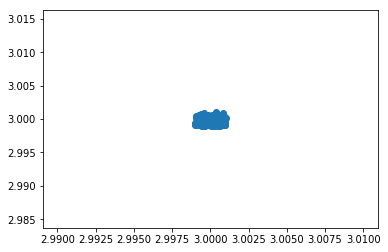

In [106]:
plt.scatter(optim_results['a_sim'], optim_results['a_mle'])

In [85]:
# Regression for a
reg = LinearRegression().fit(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))
reg.score(np.expand_dims(optim_results['a_mle'], 1), np.expand_dims(optim_results['a_sim'], 1))

0.6443843705736809

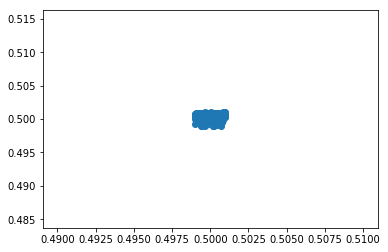

In [107]:
plt.scatter(optim_results['w_sim'], optim_results['w_mle'])

In [95]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))
reg.score(np.expand_dims(optim_results['w_mle'], 1), np.expand_dims(optim_results['w_sim'], 1))

0.9537800734751378

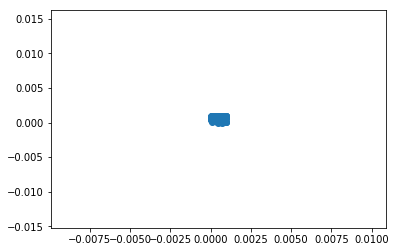

In [108]:
plt.scatter(optim_results['c1_sim'], optim_results['c1_mle'])

In [96]:
# Regression for c1
reg = LinearRegression().fit(np.expand_dims(optim_results['c1_mle'], 1), np.expand_dims(optim_results['c1_sim'], 1))
reg.score(np.expand_dims(optim_results['c1_mle'], 1), np.expand_dims(optim_results['c1_sim'], 1))

0.5987484115699703

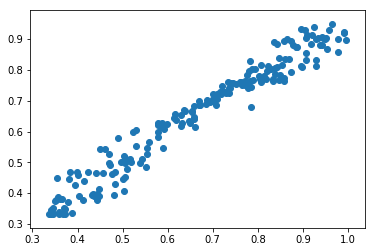

In [109]:
plt.scatter(optim_results['c2_sim'], optim_results['c2_mle'])

In [110]:
# Regression for w
reg = LinearRegression().fit(np.expand_dims(optim_results['c2_mle'], 1), np.expand_dims(optim_results['c2_sim'], 1))
reg.score(np.expand_dims(optim_results['c2_mle'], 1), np.expand_dims(optim_results['c2_sim'], 1))

0.9554382114887374

In [ ]:
# Code for running other optimization methods... (didn't work though)
#     out = minimize(log_p,
    #                    x0 = np.array([0, 1, 0.5]),
    #                    bounds = [(v_range[0],v_range[1]), 
    #                                            (a_range[0], a_range[1]), 
    #                                            (w_range[0], w_range[1])],
    #                   args = (model, ddm_dat_tmp),
    #                   method = 'Nelder-Mead'
    #                   )
    
    # Print current result